In [2]:
import pandas as pd
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
def read_data():
    #read the pickled data
    pickle_in = open(os.path.join(os.getcwd(), 'data', 'processed', 'all_data.pickle'), 'rb')
    data = pickle.load(pickle_in)

    #This copy will hold the inflation adjusted values
    data_orig = data.copy()

    #the scorers for monetary variables is the middle value of the bin with assumed
    #values for the uppermost bin
    income_scorer = np.array([5, 12.5, 17.5, 22.5, 27.5, 32.5, 37.5, 42.5, 47.5,
                              55, 67.5, 87.5, 112.5, 137.5, 175, 300]) * 1000
    rent_scorer = np.array([50, 125, 175, 225, 275, 325, 375, 425, 475, 525, 575,
                            625, 675, 725, 775, 850, 950, 1125, 1375, 1750, 2500])
    value_scorer = np.array([5, 12.5, 17.5, 22.5, 27.5, 32.5, 27.5, 45, 55, 65, 75, 
                             85, 95, 112.5, 137.5, 162.5, 187.5, 225, 275, 350, 450, 
                             625, 875, 1500]) * 1000
    #education gets a simple 1-8 score
    education_scorer = np.arange(1, 8)

    #to adjust the values to 2016 dollars, the index are adjusted by the 
    #yearly average consumer price index 
    inflation_correction = np.array([1.39422697, 1.11865482, 1.10084296, 1.06686838,
                                     1.04536021, 1.03039158, 1.01380104, 1.01263642, 
                                     1.00000000])

    #these are special cases and need to be dropped (make description below)
    to_drop = [48453980000, 48453002319, 48453001606]

    for i, year in enumerate(data.keys()):
        for key in data[year].keys():
            tmp = data[year][key]
            #bust out the total population and total households from the race and families df
            if key == 'race':
                population = tmp['total_population'].to_frame()
            if key == 'unemployment':
                tmp['employed'] = tmp['total_in_labor_force'] - tmp['unemployed']
            #convert columns to percentages and drop the total
            tmp = tmp[tmp.columns[1:]].divide(tmp[tmp.columns[0]], axis=0).fillna(0)
            #calculate the index (single number to represent bins) 
            if len(tmp.columns) > 1:
                if key == 'income':
                    tmp['income_index'] = tmp.dot(income_scorer) * inflation_correction[i]
                elif key == 'rent':
                    tmp['rent_index'] = tmp.dot(rent_scorer) * inflation_correction[i]
                elif key == 'value':
                    tmp['value_index'] = tmp.dot(value_scorer) * inflation_correction[i]
                elif key == 'education':
                    tmp['education_index'] = tmp.dot(education_scorer)
            #put the new percentage dataframe back in
            data[year][key] = tmp[tmp.columns[-1]].copy().drop(to_drop).to_frame()
        data[year] = pd.concat([data[year][key] for key in data[year].keys()], axis=1)
    return data, data_orig

In [5]:
data, data_orig = read_data()
x = pd.concat([data[year] for year in data.keys()])

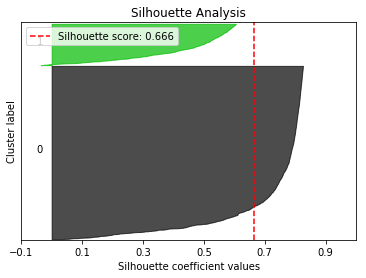

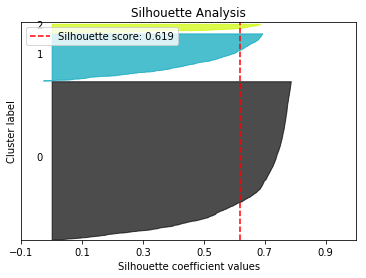

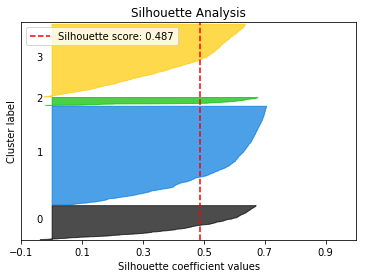

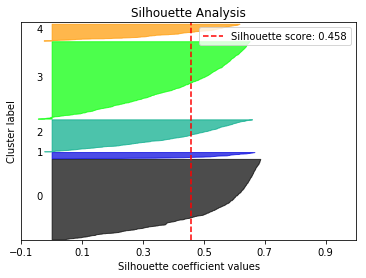

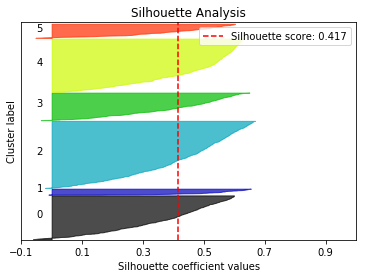

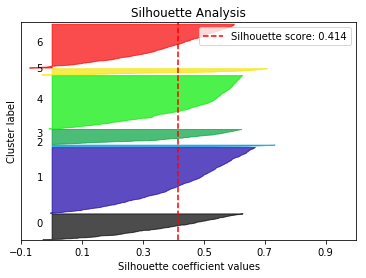

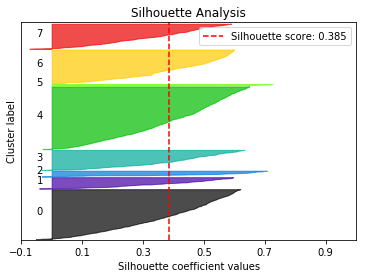

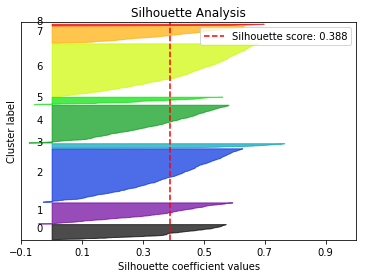

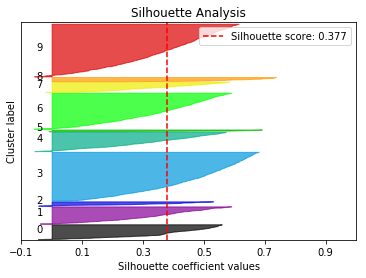

In [19]:
from sklearn.cluster import KMeans
import scikitplot as skplt
from sklearn.metrics import silhouette_score

wcss = []
sil_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(x)
    wcss.append(kmeans.inertia_)
    skplt.metrics.plot_silhouette(x, kmeans.labels_)
    sil_scores.append(silhouette_score(x, kmeans.labels_))

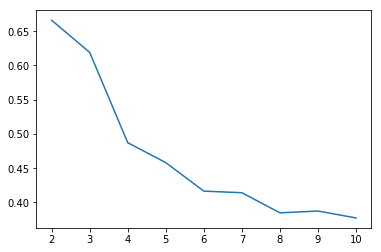

In [20]:
plt.plot(range(2, 11), sil_scores)

In [7]:
kmeans = KMeans(n_clusters=4)
clusters = kmeans.fit_predict(x)
x['cluster'] = clusters

In [12]:
for geoid in x.index.unique():
    if len(x.loc[geoid]['cluster'].unique()) > 2:
        display(x.loc[geoid])

,income_index,education_index,white_alone,rent_index,value_index,employed,cluster
geoid,,,,,,,
48453000500,53411.987900,5.895455,0.806016,1026.074828,342342.049942,0.945490,0
48453000500,56074.942884,5.864071,0.828118,979.473348,501274.088559,0.959970,1
48453000500,48099.127865,5.749167,0.803591,1012.755382,486131.359765,0.962053,1
48453000500,48545.456116,5.849767,0.845173,1080.867948,409308.540817,0.949918,1
48453000500,53373.884835,5.895575,0.838620,1106.010293,482735.035816,0.956982,1
48453000500,50892.960174,5.791600,0.848459,1165.856133,521848.583093,0.949977,1
48453000500,51663.080607,5.708381,0.864231,1172.797440,576768.308340,0.945903,1
48453000500,60198.570336,5.713722,0.842869,1211.509254,611216.957097,0.954892,2
48453000500,62423.554706,5.777091,0.848898,1195.348837,613453.608247,0.960037,2


,income_index,education_index,white_alone,rent_index,value_index,employed,cluster
geoid,,,,,,,
48453000601,28188.649310,5.796407,0.648073,681.387356,313701.06825,0.937790,0
48453000601,15664.745267,5.181176,0.630958,1347.243792,0.00000,0.841052,3
48453000601,14683.551482,4.612836,0.647487,1288.740873,0.00000,0.860969,3
48453000601,15195.180653,4.225000,0.678606,1349.516899,0.00000,0.674997,3
48453000601,15660.415383,4.082840,0.688185,1414.919261,0.00000,0.713963,3
48453000601,14468.222578,3.837093,0.715586,1414.520631,0.00000,0.748983,3
48453000601,17248.698250,3.611276,0.713504,1280.021544,633625.65000,0.789966,2
48453000601,21752.420924,4.325333,0.731516,1323.428115,632897.76250,0.764989,2
48453000601,24056.748466,4.365385,0.727554,1260.238095,625000.00000,0.825015,2


,income_index,education_index,white_alone,rent_index,value_index,employed,cluster
geoid,,,,,,,
48453000604,25023.925839,5.566016,0.749183,1076.678197,209588.684729,0.923943,3
48453000604,23478.109088,5.094203,0.783907,1216.447727,292375.691591,0.894940,0
48453000604,20999.549978,5.071429,0.751494,1317.179016,312739.477273,0.909017,0
48453000604,21738.796373,5.038718,0.777623,1354.482548,288844.735474,0.904014,0
48453000604,18542.410221,5.129310,0.810351,1377.013181,222531.054704,0.865033,0
48453000604,16734.814069,4.955247,0.788213,1381.704942,229134.917713,0.880944,0
48453000604,17544.257384,5.276768,0.752645,1392.132567,262413.744805,0.885968,0
48453000604,13706.377011,5.031646,0.727299,1339.641269,277707.866697,0.880977,0
48453000604,15229.476406,5.196850,0.711692,1373.399183,350000.000000,0.869003,1


,income_index,education_index,white_alone,rent_index,value_index,employed,cluster
geoid,,,,,,,
48453000801,57474.638006,2.423260,0.306553,1012.959518,86772.283791,0.938290,3
48453000801,52037.829481,3.199478,0.662214,699.159262,160952.467276,0.879479,3
48453000801,48346.075665,2.807692,0.601056,782.461908,162859.534725,0.864865,3
48453000801,49380.002968,2.990654,0.605452,761.263525,164186.598397,0.938619,3
48453000801,47524.996843,3.072816,0.636364,849.633192,223929.148453,0.943894,0
48453000801,51055.818469,3.340753,0.666667,760.147970,241401.260514,0.944324,0
48453000801,46068.070721,3.195635,0.691622,886.979541,256258.163755,0.925214,0
48453000801,48751.926656,3.248000,0.761905,855.810518,315067.311744,0.905916,0
48453000801,55363.924051,3.303167,0.798060,880.054152,360448.529412,0.925017,1


,income_index,education_index,white_alone,rent_index,value_index,employed,cluster
geoid,,,,,,,
48453001100,115330.940435,4.467809,0.668902,1278.513863,285898.349682,0.949145,0
48453001100,98999.145346,5.076974,0.783481,1717.537777,414386.596847,0.872048,1
48453001100,116665.661945,5.240378,0.820255,1766.176585,470091.168358,0.877856,1
48453001100,131377.018552,5.584889,0.805263,1895.664350,441442.145561,0.899033,1
48453001100,136497.909421,5.591971,0.825198,1902.898924,478529.280625,0.914940,1
48453001100,157336.541513,5.713838,0.817534,1925.989423,534296.128058,0.929919,1
48453001100,153044.634473,5.634580,0.806385,1919.481422,609077.518771,0.947063,2
48453001100,158691.368005,5.720091,0.813543,1991.042524,476802.862688,0.970014,1
48453001100,155870.851371,5.729704,0.840182,1909.560599,475374.812594,0.981910,1


,income_index,education_index,white_alone,rent_index,value_index,employed,cluster
geoid,,,,,,,
48453001307,55060.115203,3.878009,0.597539,899.920987,141561.122043,0.957185,3
48453001307,50780.635238,4.162444,0.674934,828.182027,235969.047731,0.928129,0
48453001307,51546.880973,4.247748,0.698514,878.521286,267918.432821,0.906051,0
48453001307,59160.860194,4.548594,0.739153,890.629271,282382.279046,0.913882,0
48453001307,53538.930361,4.730949,0.853270,937.760633,281174.973358,0.902105,0
48453001307,54748.231862,4.711459,0.881572,952.788189,278120.459004,0.902007,0
48453001307,55230.177254,4.748606,0.867940,958.428304,282611.278679,0.910085,0
48453001307,66647.784400,4.856877,0.826297,992.825654,313761.499982,0.953000,0
48453001307,74845.712725,4.929512,0.852557,991.926869,419303.005008,0.964080,1


,income_index,education_index,white_alone,rent_index,value_index,employed,cluster
geoid,,,,,,,
48453001403,68706.132103,4.620162,0.712725,987.622645,172113.650428,0.975456,3
48453001403,58753.315029,4.571577,0.648176,951.954584,281562.913743,0.917407,0
48453001403,58025.175003,4.435205,0.657353,997.503435,320240.357187,0.899567,0
48453001403,59146.365572,4.303588,0.671483,980.015690,359530.065226,0.832934,1
48453001403,57982.834923,4.520677,0.781513,942.068665,296135.327689,0.896125,0
48453001403,54165.179003,4.463229,0.758699,906.666530,285173.700311,0.899180,0
48453001403,53949.614837,4.447096,0.861015,947.853784,276639.502179,0.928244,0
48453001403,54860.765238,4.361561,0.816688,1041.111097,274677.628925,0.916837,0
48453001403,58503.144654,4.535578,0.835660,1109.626437,296602.316602,0.927813,0


,income_index,education_index,white_alone,rent_index,value_index,employed,cluster
geoid,,,,,,,
48453001504,69713.224478,4.543161,0.879467,1166.080739,165931.123863,0.984588,3
48453001504,74670.495482,4.773579,0.844720,1085.969366,250640.356356,0.915980,0
48453001504,76118.447403,4.727569,0.824771,1074.178830,262248.082876,0.933083,0
48453001504,74595.534561,4.929224,0.845177,1083.003118,256999.462648,0.938022,0
48453001504,79912.744650,5.128655,0.875832,1138.386709,257003.945294,0.942933,0
48453001504,79994.740250,5.157297,0.872753,1224.121131,260049.896353,0.965972,0
48453001504,86779.068952,5.156627,0.864994,1333.455236,284264.864444,0.980963,0
48453001504,94286.139507,5.188003,0.879379,1348.243691,322355.927033,0.986921,0
48453001504,105023.933856,5.299439,0.825861,1400.192097,351825.454545,0.985947,1


,income_index,education_index,white_alone,rent_index,value_index,employed,cluster
geoid,,,,,,,
48453001602,77892.631454,5.952117,0.636183,1037.693307,320999.346800,0.975410,0
48453001602,84112.069304,5.909977,0.723783,1083.186882,593320.336396,0.975984,2
48453001602,79270.228498,5.929120,0.752830,1074.637052,568982.567976,0.958828,1
48453001602,79380.964265,5.890068,0.729128,1112.721968,553148.532681,0.957127,1
48453001602,80477.460894,6.017992,0.751125,1122.274716,578483.611640,0.958018,1
48453001602,79673.348937,6.052961,0.732001,1132.447540,584507.088019,0.972004,1
48453001602,83561.642795,6.005700,0.670368,1095.795857,621686.664750,0.958864,2
48453001602,100496.045880,6.032762,0.680095,1150.091597,639931.366301,0.983121,2
48453001602,103326.979472,6.186166,0.666667,1146.217105,609302.694136,0.989888,2


,income_index,education_index,white_alone,rent_index,value_index,employed,cluster
geoid,,,,,,,
48453001750,84647.494855,4.767283,0.702047,1301.997106,170990.319312,0.978857,3
48453001750,74043.862497,4.897444,0.753994,1041.576015,292084.804691,0.941926,0
48453001750,73881.327819,4.854394,0.718080,1093.853719,294638.713985,0.934987,0
48453001750,74916.819427,4.934634,0.757806,1109.714319,293320.995069,0.946008,0
48453001750,78418.648371,5.075722,0.860744,1102.743040,293456.580990,0.956026,0
48453001750,79023.140225,5.117409,0.865765,1107.017621,279084.552546,0.956012,0
48453001750,79576.352840,5.193512,0.871339,1115.941333,264651.958708,0.962112,0
48453001750,83884.394768,5.185522,0.863241,1148.659453,314492.389080,0.981105,0
48453001750,87124.501992,5.115668,0.868920,1216.059502,339087.485516,0.976953,1


,income_index,education_index,white_alone,rent_index,value_index,employed,cluster
geoid,,,,,,,
48453001766,95774.236492,3.762134,0.917490,952.666699,172803.621113,0.974023,3
48453001766,81823.123660,4.109082,0.856053,920.189424,219744.385303,0.938910,0
48453001766,81692.458097,4.022429,0.854698,977.126251,243155.413864,0.908018,0
48453001766,81361.100218,3.948090,0.880738,960.181542,248099.119024,0.915018,0
48453001766,78583.488770,3.971700,0.900469,973.192947,291209.360599,0.921935,0
48453001766,84216.476919,4.097697,0.943300,1016.371133,294996.535186,0.915977,0
48453001766,87484.729294,4.182453,0.978048,932.612630,302896.147011,0.934986,0
48453001766,86923.182524,4.227326,0.982686,909.535796,304425.661801,0.955970,0
48453001766,107948.626472,4.461245,0.950137,876.310861,356250.000000,0.952061,1


,income_index,education_index,white_alone,rent_index,value_index,employed,cluster
geoid,,,,,,,
48453002211,63455.849474,2.856833,0.354589,872.844176,64957.299259,0.976802,3
48453002211,50814.784659,2.906599,0.478364,964.231818,109942.794028,0.934765,3
48453002211,69874.499647,3.179679,0.614127,660.505776,287585.370887,0.964187,0
48453002211,56223.019495,3.445535,0.523024,702.197662,377038.838542,0.918919,1
48453002211,58125.052834,3.406806,0.629449,689.581366,310749.962051,0.921831,0
48453002211,63308.837501,3.655951,0.700446,746.676121,146839.386746,0.926270,3
48453002211,63692.560641,3.384298,0.662809,955.266099,166851.342407,0.954931,3
48453002211,63534.768932,3.463796,0.644904,1019.077746,179527.228965,0.977904,3
48453002211,71130.410023,3.454237,0.601517,1136.635945,167919.818457,0.969871,3


In [9]:
x.index.unique()

Int64Index([48021950100, 48021950200, 48021950300, 48021950400, 48021950600,
            48021950700, 48055960200, 48055960300, 48055960400, 48055960500,
            ...
            48491020804, 48491020806, 48491021504, 48491021505, 48491021506,
            48491021507, 48491021508, 48491021601, 48491021602, 48491021603],
           dtype='int64', name='geoid', length=347)